In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from tabulate import tabulate

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Zaciągamy dane do analizy
df = pd.read_csv('/content/drive/MyDrive/internet_service_churn.csv')
# df = pd.read_csv('/content/sample_data/internet_service_churn.csv')

# Sprawdzamy informacje o danych
print(f'Zaciągnięte dane:')
print(df.head(), '\n')

print(f'\nOgólne informacje o danych:')
print({df.info()}, '\n')

print(f'\nSprawdzamy czy kolumny mają jakieś puste dane:')
print(df.isnull().sum(), '\n')

print(f'\nSprawdzamy podstawowe statystyki opisowe:')
print(df.describe())


Zaciągnięte dane:
   id  is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
0  15                 1                            0             11.95   
1  18                 0                            0              8.22   
2  23                 1                            0              8.91   
3  27                 0                            0              6.87   
4  34                 0                            0              6.39   

   bill_avg  reamining_contract  service_failure_count  download_avg  \
0        25                0.14                      0           8.4   
1         0                 NaN                      0           0.0   
2        16                0.00                      0          13.7   
3        21                 NaN                      1           0.0   
4         0                 NaN                      0           0.0   

   upload_avg  download_over_limit  churn  
0         2.3                    0      0  
1         0.0   

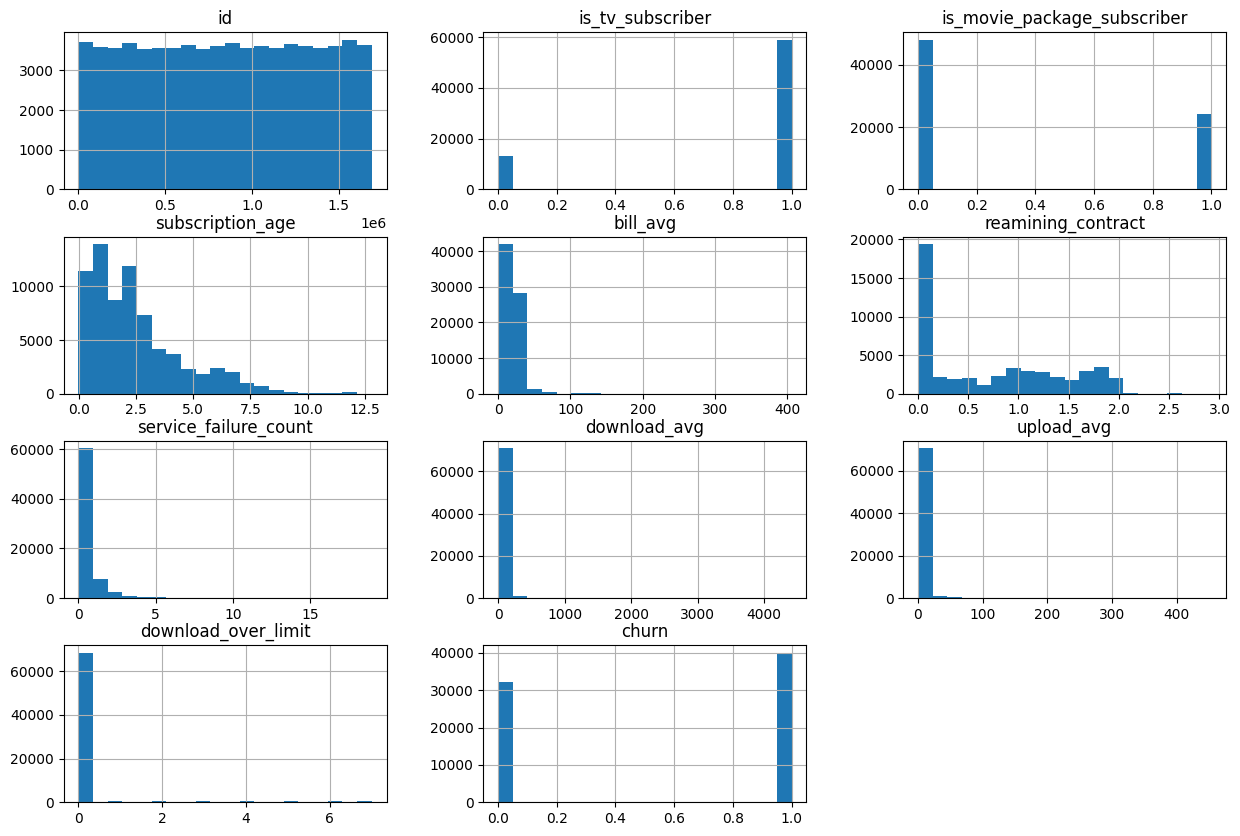

In [4]:
# Histogram dla cech liczbowych
df.hist(bins=20, figsize=(15, 10))
plt.show()

In [5]:
# Usuwanie kolumny 'id'
df = df.drop(columns=['id'])

# Obliczamy średnią dla kolumn 'download_avg' i 'upload_avg'
download_avg_mean = df['download_avg'].mean()
upload_avg_mean = df['upload_avg'].mean()

# Wypełnienie brakujących wartości w kolumnach
df['download_avg'].fillna(download_avg_mean, inplace=True)
df['upload_avg'].fillna(upload_avg_mean, inplace=True)
df['reamining_contract'].fillna(0, inplace=True)

<ipython-input-5-d86fce060fba>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['download_avg'].fillna(download_avg_mean, inplace=True)
<ipython-input-5-d86fce060fba>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

In [6]:
# Standaryzacja danych i zastąpienie NAN wartosciami obliczonymi wartość x -  srednia z x /odchylenie stadardowe z x gdzie x - to wartość wiersza z wybranej kolumny

# # Normalizacja kolumn tylko w przypadku kolumn zawierających NaN
# for column in df.columns:
#     if df[column].isnull().any():
#         df[column] = (df[column] - df[column].mean()) / df[column].std()

# # Zastępowanie NaN obliczonymi wartościami dla każdej kolumny
# for column in df.columns:
#     if df[column].isnull().any():
#         mean_value = df[column].mean()
#         df[column].fillna(mean_value, inplace=True)

# Sprawdzenie likwidacji wierszy z wartościami NaN poprzez drukowanie kolumn, które nadal mają wartości NaN
columns_with_nan = df.columns[df.isnull().any()].tolist()
if columns_with_nan == []:
    print("Brak kolumn z wartościami NaN ! ")
else:
    print(columns_with_nan)

Brak kolumn z wartościami NaN ! 


Test Shapiro-Wilka

1. Iteruje przez każdą kolumnę w DataFrame df.
2. Oblicza statystykę testu Shapiro-Wilka oraz wartość p (p_value) dla kolumny, pomijając brakujące wartości (NaN).
3. Wyświetlam nazwę kolumny, statystykę testu oraz wartość p.
4. Sprawdzam, czy wartość p jest większa niż 0.05. Jeśli tak, przyjmuje, że kolumna ma rozkład normalny. W przeciwnym razie, przyjmuje, że kolumna nie ma rozkładu normalnego.

In [7]:
# Test Shapiro-Wilka dla każdej kolumny
for column in df.columns:
    stat, p_value = shapiro(df[column].dropna())  # Pomijanie NaN
    print(f"Kolumna: {column}, Statystyka: {stat}, P-wartość: {p_value}")
    if p_value > 0.05:
        print(f"Kolumna '{column}' ma rozkład normalny (p > 0.05)\n")
    else:
        print(f"Kolumna '{column}' nie ma rozkładu normalnego (p <= 0.05)\n")

Kolumna: is_tv_subscriber, Statystyka: 0.4722561947181141, P-wartość: 9.76028199782854e-154
Kolumna 'is_tv_subscriber' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: is_movie_package_subscriber, Statystyka: 0.5955905726496986, P-wartość: 2.4664420868399117e-145
Kolumna 'is_movie_package_subscriber' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: subscription_age, Statystyka: 0.8850806872092419, P-wartość: 7.469613795969005e-109
Kolumna 'subscription_age' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: bill_avg, Statystyka: 0.6476717704116177, P-wartość: 4.467243408610441e-141
Kolumna 'bill_avg' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: reamining_contract, Statystyka: 0.74537091184431, P-wartość: 2.670764923918929e-131
Kolumna 'reamining_contract' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: service_failure_count, Statystyka: 0.3753587891580299, P-wartość: 3.5046137918288053e-159
Kolumna 'service_failure_count' nie ma rozkładu normalnego (p <= 0.05)

Kolumna: download_avg

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 72274.
  res = hypotest_fun_out(*samples, **kwds)


1. Iteruję przez każdą kolumnę w DataFrame df.
2. Tworzę wykres Q-Q, używając stats.probplot, pomijając brakujące wartości(NaN) i porównując je z rozkładem normalnym.
3. Ustawiam tytuł wykresu na "Q-Q Plot for {column}" i wyświetla wykres.

PODSUMOWANIE TESTU: Kod ten pomaga zarówno statystycznie, jak i wizualnie ocenić, czy dane w każdej kolumnie mają rozkład normalny.

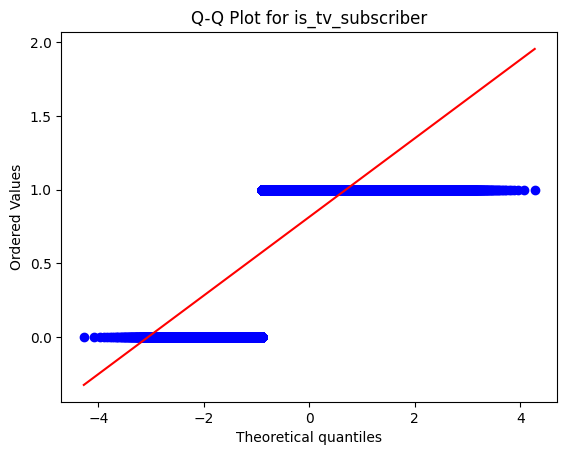

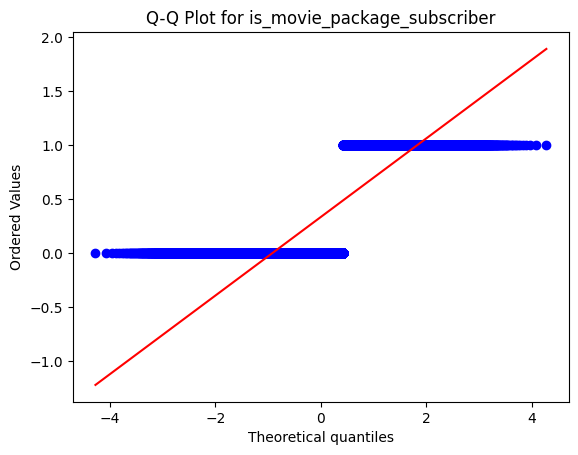

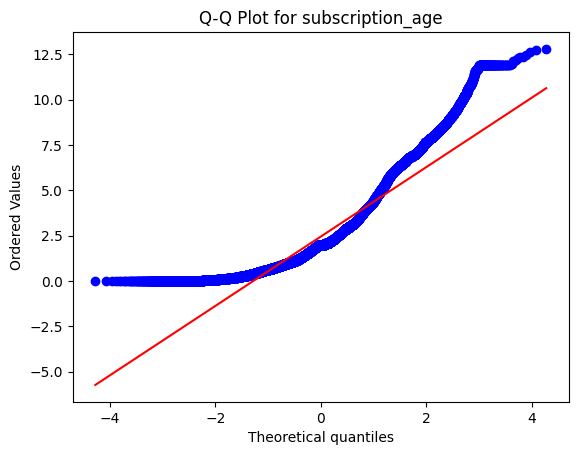

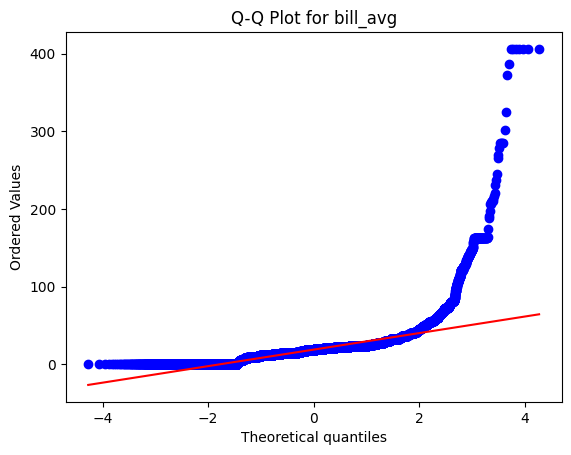

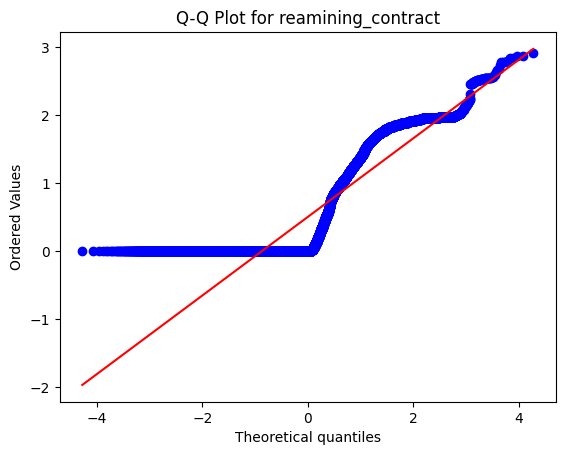

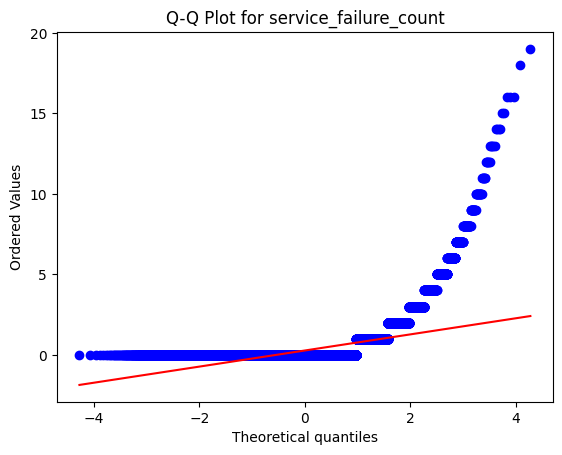

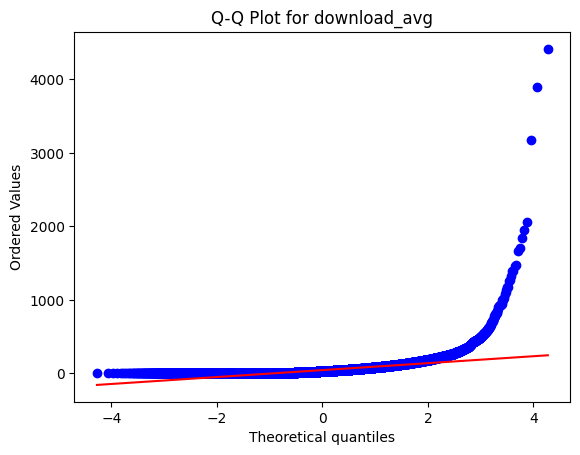

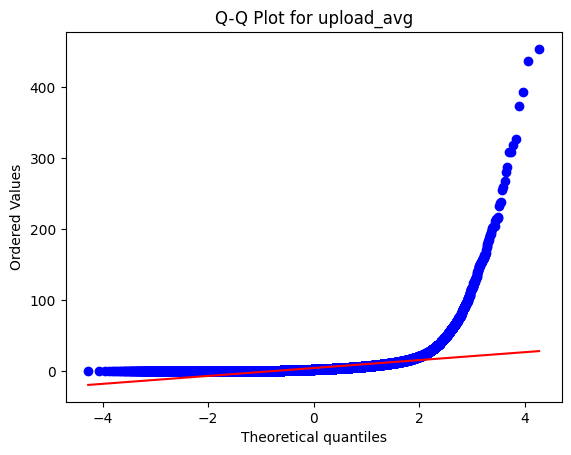

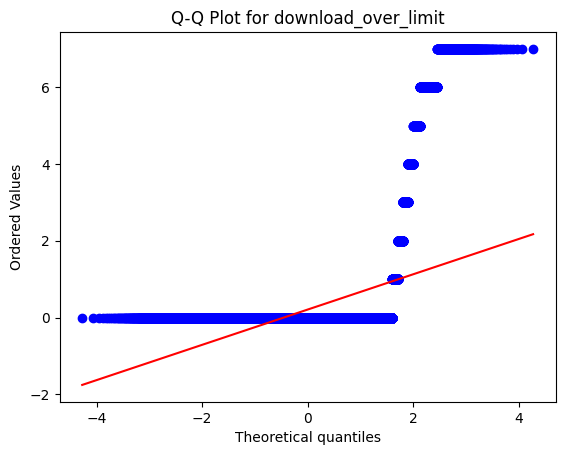

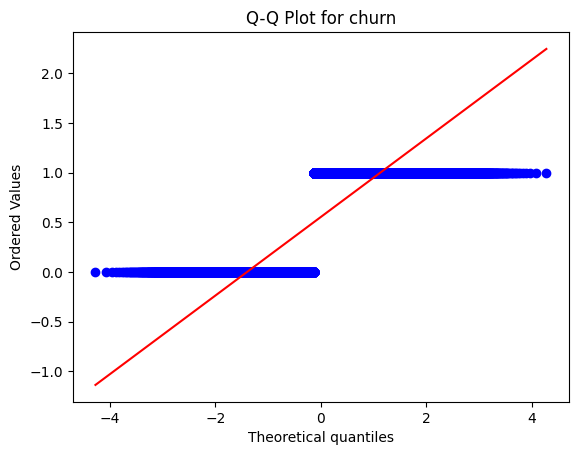

In [8]:
# Wykres Q-Q dla każdej kolumny
for column in df.columns:
    stats.probplot(df[column].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {column}")
    plt.show()

In [9]:
percentiles = [25, 50, 75]  # Możena podać dowolne percentyle (np. 25%, 50%, 75%)

# Obliczenie percentyli
subscription_age_percentiles = df['subscription_age'].quantile([p / 100 for p in percentiles])
bill_avg_percentiles = df['bill_avg'].quantile([p / 100 for p in percentiles])
reamining_contract_percentiles = df['reamining_contract'].quantile([p / 100 for p in percentiles])
download_percentiles = df['download_avg'].quantile([p / 100 for p in percentiles])
upload_percentiles = df['upload_avg'].quantile([p / 100 for p in percentiles])

print("Percentyle dla subscription_age:\n", subscription_age_percentiles)
print("\nPercentyle dla bill_avg:\n", bill_avg_percentiles)
print("\nPercentyle dla reamining_contract:\n", reamining_contract_percentiles)
print("\nPercentyle dla download_avg:\n", download_percentiles)
print("\nPercentyle dla upload_avg:\n", upload_percentiles)

# *te same informacje można uzyskać za pomocą 'print(df.describe())' tylko tyle że nie można tam zmienić zakresu procentyli, dodałem ten kod na początku

Percentyle dla subscription_age:
 0.25    0.93
0.50    1.98
0.75    3.30
Name: subscription_age, dtype: float64

Percentyle dla bill_avg:
 0.25    13.0
0.50    19.0
0.75    22.0
Name: bill_avg, dtype: float64

Percentyle dla reamining_contract:
 0.25    0.00
0.50    0.00
0.75    1.04
Name: reamining_contract, dtype: float64

Percentyle dla download_avg:
 0.25     6.8
0.50    28.1
0.75    60.2
Name: download_avg, dtype: float64

Percentyle dla upload_avg:
 0.25    0.5
0.50    2.1
0.75    4.8
Name: upload_avg, dtype: float64


Macierz korelacji:
                              is_tv_subscriber  is_movie_package_subscriber  \
is_tv_subscriber                     1.000000                     0.337435   
is_movie_package_subscriber          0.337435                     1.000000   
subscription_age                     0.087276                     0.131986   
bill_avg                            -0.076245                    -0.022534   
reamining_contract                   0.255366                     0.344025   
service_failure_count               -0.016041                     0.013345   
download_avg                         0.131312                     0.160099   
upload_avg                           0.065622                     0.092966   
download_over_limit                 -0.103546                    -0.026352   
churn                               -0.327582                    -0.307167   

                             subscription_age  bill_avg  reamining_contract  \
is_tv_subscriber                     0.087

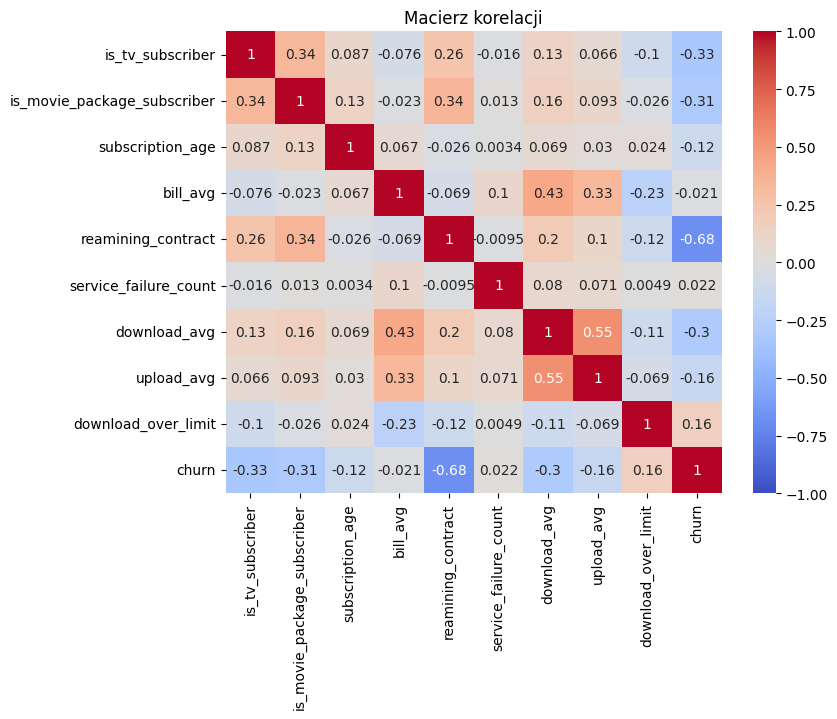

In [10]:
# Obliczenie macierzy korelacji wraz z jej wizualicją
correlation_matrix = df.corr()

print("Macierz korelacji:\n", correlation_matrix)

# Wykres macierzy korelacji
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Macierz korelacji")
plt.show()

In [11]:
# Koduje kolumnę 'churn' i jednocześnie zastąpuje zakodowane wartości etykietami tekstowymi tzn: cyfra 0 zastępowana "pozostaje", a cyfra 1 zastępowana 'odchodzi'.

# Inicjalizacja LabelEncoder
label_encoder = LabelEncoder()

# Tworzenie kopii DataFrame
df_standard =  df.copy()

# Zakodowanie etykiet w kolumnie 'churn'
df_standard['churn_encoded'] = label_encoder.fit_transform(df_standard['churn'])

# Zastąpienie zakodowanych wartości etykietami tekstowymi tzn: cyfra 0 zastępowana "pozostaje", a cyfra 1 zastępowana 'odchodzi'.
df_standard['churn_encoded'] = df['churn'].replace({0: 'pozostaje', 1: 'odchodzi'})

# Wyświetlenie DataFrame po dodaniu kolumny z zakodowanymi danymi
print("\nDataFrame po dodaniu kolumny Label Encoding:\n", df_standard)


DataFrame po dodaniu kolumny Label Encoding:
        is_tv_subscriber  is_movie_package_subscriber  subscription_age  \
0                     1                            0             11.95   
1                     0                            0              8.22   
2                     1                            0              8.91   
3                     0                            0              6.87   
4                     0                            0              6.39   
...                 ...                          ...               ...   
72269                 1                            1              0.09   
72270                 1                            0              0.06   
72271                 1                            0              0.02   
72272                 0                            0              0.01   
72273                 1                            1              0.01   

       bill_avg  reamining_contract  service_failure_count  down

**WALIDACJA KRZYŻOWA** - im wyższe wyniki walidacji krzyżowej tym lepsza generalizację modelu, czyli jego zdolność do poprawnego przewidywania na nowych, niewidzianych wcześniej danych.

**Wynik F1 (F1 Score)** to miara skuteczności modelu, która uwzględnia zarówno precyzję (precision), jak i czułość (recall). Jest szczególnie przydatna w przypadkach, gdy masz do czynienia z niezbalansowanymi danymi.

**Precyzja (Precision)**: Odsetek trafnych pozytywnych przewidywań spośród wszystkich pozytywnych przewidywań (true positives / (true positives + false positives)).

**Czułość (Recall)**: Odsetek trafnych pozytywnych przewidywań spośród wszystkich rzeczywistych pozytywnych przypadków (true positives / (true positives + false negatives)).

**Dokładność (accuracy)** to miara wydajności modelu, która wskazuje, jak dobrze model klasyfikuje dane w porównaniu do wszystkich danych. Jest to stosunek poprawnych przewidywań (zarówno prawdziwie pozytywnych, jak i prawdziwie negatywnych) do całkowitej liczby przewidywań.

In [12]:
# MODEL LOSOWEGO LASU

print("RandomForestClassifier")

# Przygotowanie danych wejściowych i wyjściowych: wykluczamy kolumny: 'churn', 'churn_encoded', 'subscription_age', 'service_failure_count' i 'upload_avg'. Określamy kolumnę docelową (target), którą chcemy przewidzieć (churn).

X = df_standard.drop(columns=['churn', 'churn_encoded', 'subscription_age', 'service_failure_count', 'upload_avg'])
y = df_standard['churn']

# Skalowanie danych (opcjonalne, ale zalecane) - aby miały średnią 0 i odchylenie standardowe 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zestaw treningowy i testowy ( zestaw treningowy (X_train, y_train) i testowy (X_test, y_test) w stosunku 80/20 oraz random_state=42, który zapewnia powtarzalność wyników.)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicjalizacja modelu
model = RandomForestClassifier(random_state=42)

# Walidacja krzyżowa
RFC_cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Średnia dokładność z walidacji krzyżowej:", RFC_cross_val_scores.mean())

# Uczenie modelu
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
RFC_accuracy = accuracy_score(y_test, y_pred)
RFC_recall = recall_score(y_test, y_pred)
RFC_precision = precision_score(y_test, y_pred)
RFC_f1 = f1_score(y_test, y_pred)

print("\nOcena modelu:")
print("Dokładność (Accuracy):", RFC_accuracy)
print("Czułość (Recall):", RFC_recall)
print("Precyzja (Precision):", RFC_precision)
print("Wynik F1 (F1 Score):", RFC_f1)

RandomForestClassifier
Średnia dokładność z walidacji krzyżowej: 0.9309742444448744

Ocena modelu:
Dokładność (Accuracy): 0.9313040470425459
Czułość (Recall): 0.9286256643887624
Precyzja (Precision): 0.9447663190421012
Wynik F1 (F1 Score): 0.9366264598889527


In [13]:
# Model Regresji liniowej

print('LogisticRegression')

# Przygotowanie danych wejściowych i wyjściowych: wykluczamy kolumny: 'churn', 'churn_encoded', 'subscription_age', 'service_failure_count' i 'upload_avg'. Określamy kolumnę docelową (target), którą chcemy przewidzieć (churn).

X = df_standard.drop(columns=['churn', 'churn_encoded', 'subscription_age', 'service_failure_count', 'upload_avg'])
y = df_standard['churn']

# Skalowanie danych:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicjalizacja modelu regresji logistycznej
model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)

# Walidacja krzyżowa
LR_cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Średnia dokładność z walidacji krzyżowej:", LR_cross_val_scores.mean())

# Uczenie modelu
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
LR_accuracy = accuracy_score(y_test, y_pred)
LR_recall = recall_score(y_test, y_pred)
LR_precision = precision_score(y_test, y_pred)
LR_f1 = f1_score(y_test, y_pred)

print("\nOcena modelu:")
print("Dokładność (Accuracy):", LR_accuracy)
print("Czułość (Recall):", LR_recall)
print("Precyzja (Precision):", LR_precision)
print("Wynik F1 (F1 Score):", LR_f1)

LogisticRegression
Średnia dokładność z walidacji krzyżowej: 0.8637126277344335

Ocena modelu:
Dokładność (Accuracy): 0.8632307160152196
Czułość (Recall): 0.9250822576562896
Precyzja (Precision): 0.8407130534790109
Wynik F1 (F1 Score): 0.880882087124179


In [14]:

# SVC Model
print('SVC')

# Przygotowanie danych wejściowych i wyjściowych: wykluczamy kolumny: 'churn', 'churn_encoded', 'subscription_age', 'service_failure_count' i 'upload_avg'
X = df_standard.drop(columns=['churn', 'churn_encoded', 'subscription_age', 'service_failure_count', 'upload_avg'])
y = df_standard['churn']

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicjalizacja modelu SVC ze zwiększoną liczbą iteracji
model = SVC(C=0.01, random_state=42, max_iter=1000)  # Zwiększono parametr C do 10.0

# Walidacja krzyżowa
SVC_cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Średnia dokładność z walidacji krzyżowej:", SVC_cross_val_scores.mean())

# Uczenie modelu
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
SVC_accuracy = accuracy_score(y_test, y_pred)
SCV_recall = recall_score(y_test, y_pred)
SVC_precision = precision_score(y_test, y_pred)
SVC_f1 = f1_score(y_test, y_pred)

print("\nOcena modelu:")
print("Dokładność (Accuracy):", SVC_accuracy)
print("Czułość (Recall):", SCV_recall)
print("Precyzja (Precision):", SVC_precision)
print("Wynik F1 (F1 Score):", SVC_f1)


SVC


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

Średnia dokładność z walidacji krzyżowej: 0.7257820129827026


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Ocena modelu:
Dokładność (Accuracy): 0.7147007955724662
Czułość (Recall): 0.9667172867628449
Precyzja (Precision): 0.6642608695652173
Wynik F1 (F1 Score): 0.7874445933408927


In [15]:
# Model drzewa decyzyjnego
print('GradientBoostingClassifier')

# Przygotowanie danych wejściowych i wyjściowych: wykluczamy kolumny: 'churn', 'churn_encoded', 'subscription_age', 'service_failure_count' i 'upload_avg'
X = df_standard.drop(columns=['churn', 'churn_encoded', 'subscription_age', 'service_failure_count', 'upload_avg'])

# Skalowanie danych
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Inicjalizacja Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)

# Walidacja krzyżowa
GBC_cross_val_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Średnia dokładność z walidacji krzyżowej:", GBC_cross_val_scores.mean())

# Uczenie modelu
model.fit(X_train, y_train)

# Predykcja na zbiorze testowym
y_pred = model.predict(X_test)

# Ocena modelu
GBC_accuracy = accuracy_score(y_test, y_pred)
GBC_recall = recall_score(y_test, y_pred)
GBC_precision = precision_score(y_test, y_pred)
GBC_f1 = f1_score(y_test, y_pred)

print("\nOcena modelu:")
print("Dokładność (Accuracy):", GBC_accuracy)
print("Czułość (Recall):", GBC_recall)
print("Precyzja (Precision):", GBC_precision)
print("Wynik F1 (F1 Score):", GBC_f1)


GradientBoostingClassifier
Średnia dokładność z walidacji krzyżowej: 0.9333091469818703

Ocena modelu:
Dokładność (Accuracy): 0.9331719128329298
Czułość (Recall): 0.9336876740065806
Precyzja (Precision): 0.9434782608695652
Wynik F1 (F1 Score): 0.9385574354407836


PORÓWNANIE MODELI:
+----+----------------------------+----------------------------------+------------+----------+-------------+------------+
|    | Model                      |   Cross-Validation Accuracy Mean |   Accuracy |   Recall |   Precision |   F1 Score |
+====+============================+==================================+============+==========+=============+============+
|  0 | RandomForestClassifier     |                         0.930974 |   0.931304 | 0.928626 |    0.944766 |   0.936626 |
+----+----------------------------+----------------------------------+------------+----------+-------------+------------+
|  1 | LogisticRegression         |                         0.863713 |   0.863231 | 0.925082 |    0.840713 |   0.880882 |
+----+----------------------------+----------------------------------+------------+----------+-------------+------------+
|  2 | Support Vector Classifier  |                         0.725782 |   0.714701 | 0.966717 |    0.664261 |   0.787445 |
+----

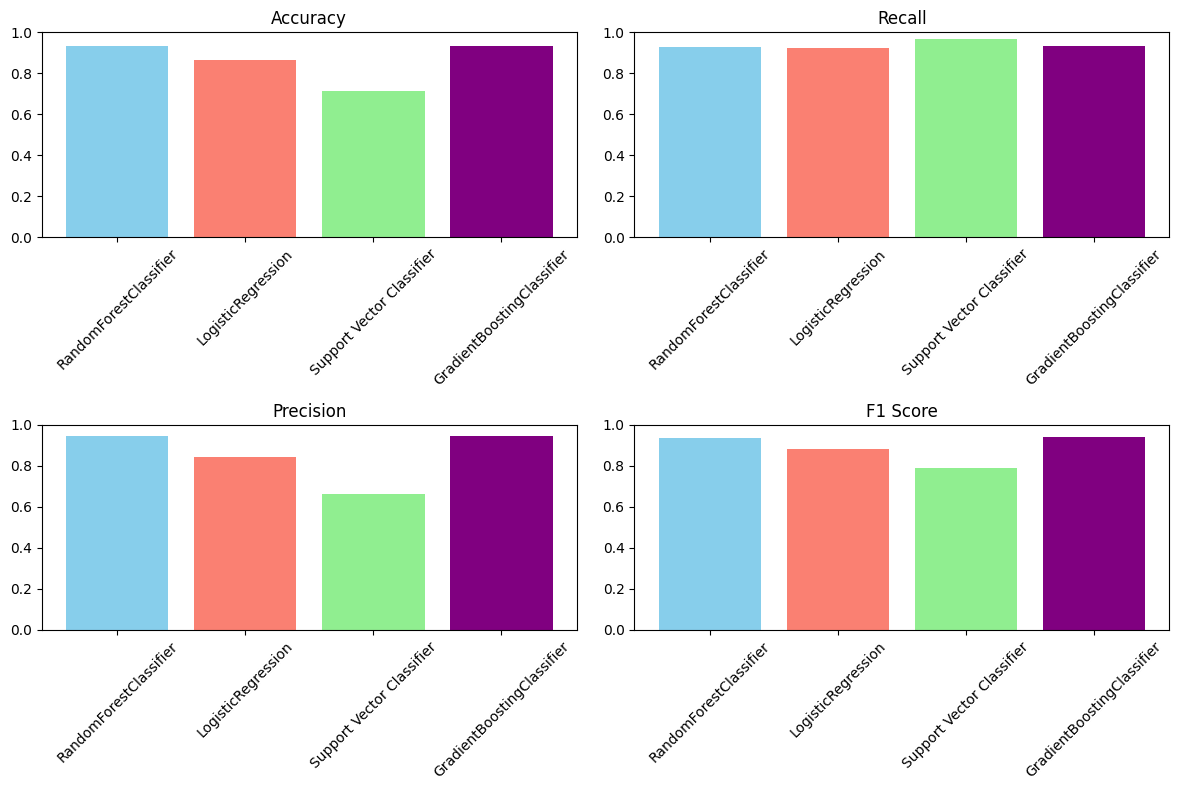

In [16]:
print('PORÓWNANIE MODELI:')

# Dane wyników dla każdego modelu
data = {
    "Model": ["RandomForestClassifier", "LogisticRegression", "Support Vector Classifier", "GradientBoostingClassifier"],
    "Cross-Validation Accuracy Mean": [RFC_cross_val_scores.mean(), LR_cross_val_scores.mean(), SVC_cross_val_scores.mean(), GBC_cross_val_scores.mean()],
    "Accuracy": [RFC_accuracy, LR_accuracy, SVC_accuracy, GBC_accuracy],
    "Recall": [RFC_recall, LR_recall, SCV_recall, GBC_recall],
    "Precision": [RFC_precision, LR_precision, SVC_precision,  GBC_precision],
    "F1 Score": [RFC_f1, LR_f1, SVC_f1, GBC_f1]
}

# Tworzenie DataFrame z danymi
df_results = pd.DataFrame(data)

# # Wyświetlenie tabeli wyników
# print("Tabela wyników:")
# print(df_results)

# Wyświetlenie tabeli z liniami oddzielającymi wiersze i kolumny
print(tabulate(df_results, headers="keys", tablefmt="grid"))

# Utworzenie wykresu słupkowego dla każdej z miar
metrics = ["Accuracy", "Recall", "Precision", "F1 Score"]
df_metrics = df_results.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    subset = df_metrics[df_metrics["Metric"] == metric]
    plt.bar(subset["Model"], subset["Score"], color=["skyblue", "salmon", "lightgreen", "purple"])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()